## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Explore and Clean](#explore_clean)
- [Part II - Probability](#probability)
- [Part III - A/B Test](#ab_test)
- [Part IV - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

An e-commerce website has submitted the results of an A/B test run to determine whether they should try a new page design to increase conversions.  This notebook analyzes these results using hypothesis testing and a logistic regression model.


<a id='explore_clean'></a>
### Part I - Explore and Clean

Import libraries.

In [63]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Set the seed so I can check my answers online.
random.seed(42)

Read in data and look at a small subset.

In [64]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows in data set and the number of unique users.

In [65]:
df.shape[0], df.user_id.nunique()

(294478, 290584)

Check for missing values.

In [66]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no null values in our dataset.<br>
Proportion of users converted.

In [67]:
df.converted.mean()

0.11965919355605512

Check for mixups in the data. Were users ever sent to the wrong page based on their group (`treatment` + `old page`, `control` + `new page`)? If so, how many times did this happen?

In [68]:
page_mixups = df.query(('(group == "control" & landing_page != "old_page") | \
                          (group == "treatment" & landing_page != "new_page")'))
page_mixups.shape[0]


3893

3893 users were sent to the incorrect page. <br>
Confirm page_mixups contains users sent to the wrong page.

In [69]:
page_mixups.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


We can't know to which page users in the page_mixups subset were actually sent.<br>
Remove these rows from the dataset so as not to pollute the results. 

In [70]:
df2 = df.drop(page_mixups.index)

Confirm that no page/group mixups are present in the new dataframe, df2.

In [71]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of rows in the new dataset and number of unique users.

In [72]:
df2.shape[0], df2.user_id.nunique()

(290585, 290584)

The previous result indicates that there is **one** duplicate user.<br>
Find repeated user_id so we can remove one instance.

In [73]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate user_id, but keep the dataframe as df2, then confirm removal by checking shape of updated df2.

In [74]:
df2.drop_duplicates('user_id', inplace=True)
df2.shape[0]

290584

>**Discussion**: We removed 3893 rows of mismatched data, along with one duplicate user entry. There were no null values to deal with, so the dataset is now clean and ready for analysis. 

<a id='probability'></a>
### Part II - Probability

Confirm the probability of an individual converting for the new dataframe.

In [75]:
p_conv = df2.converted.mean() #or df2['converted'].mean() (what's the difference, here?)
p_conv

0.11959708724499628

Probability of conversion for `control` group sent to `old_page`.

In [76]:
p_conv_control = df2.query('group == "control"').converted.mean()
p_conv_control


0.1203863045004612

Probability of conversion for `treatment` group sent to `new_page`.

In [77]:
p_conv_treat = df2.query('group == "treatment"').converted.mean()
p_conv_treat

0.11880806551510564

Probability that an individual received the `new_page`.

In [78]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.50006194422266881

>**Discussion**: There is no need to weight these calculations to make a preliminary assessment (like we do with click through rate) since the sample was evenly split between the two groups. Based on the results above, there's no evidence to suggest that the new page leads to more conversions. For this sample, the probability of a `new_page` visitor converting (11.88%) is less than the probability of an `old_page` visitor converting (12.03%).

<a id='ab_test'></a>
### Part III - A/B Test 

Null hypothesis: Visitors to the old page are equally or more likely to convert than visitors to the new page.<br>
Alternative hypothesis: Visitors to the old page are less likely to convert than visitors to the new page.

**$H_{0}: p_{old} - p_{new} \geq 0$**

**$H_{1}: p_{old} - p_{new} < 0$**

We will assume that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are both equal to the **p_conv**. I'll use a sample size for each page equal to the respective sample in **ab_data.csv**, then perform the sampling distribution for the difference in conversion rates between the two pages over 10,000 iterations of calculating an estimate from the null.<br><br>
An isolated iteration is shown prior to the 10000 iterations so the process is clear.

The conversion rate for $p_{new}$ and $p_{old}$ under the null. 

In [79]:
p_conv

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group.

In [80]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

$n_{old}$, the number of individuals in the control group.

In [81]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null using np.random.choice and store them in array.

In [82]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1 - p_conv, p_conv])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null using np.random.choice and store them in array.

In [83]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1 - p_conv, p_conv])
old_page_converted

array([1, 0, 0, ..., 0, 1, 0])

Find difference in conversion rate $(p_{old}$ - $p_{new})$ for simulated values from the previous two steps.

In [84]:
p_diff = old_page_converted.mean() - new_page_converted.mean()
p_diff

-0.00052094867144455992

Run 10,000 iterations of the same simulation process used above.<br> 
Store all 10,000 $p_{old}$ - $p_{new}$ values in a NumPy array called **p_diffs**.<br>
We will make a histogram of these differences under the null and see how they compare to our observed difference.

In [85]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_conv), p_conv])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_conv), p_conv])
    p_diffs.append(old_page_converted.mean() - new_page_converted.mean())

In [86]:
p_diffs = np.asarray(p_diffs)

Histogram of the **p_diffs**.

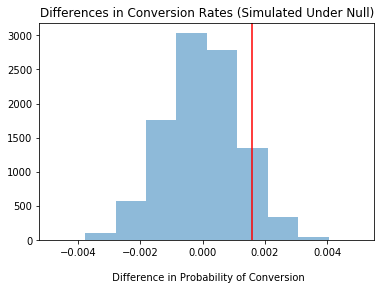

In [87]:
plt.hist(p_diffs, alpha=0.5)
plt.title("Differences in Conversion Rates (Simulated Under Null)")
plt.xlabel("\n Difference in Probability of Conversion")
plt.axvline(p_conv_control - p_conv_treat, color='red');

Find p-value: This is the proportion of `p_diffs` less than (for an explanation of why less than, see below) the actual difference `obs_diff` observed in **ab_data.csv**.<br><br>
Recall:<br>
$H_{0}$ states that $p_{old} - p_{new} \geq 0$  (old page equally or more effective at creating conversions than new page). <br>
$H_{1}$ states that $p_{old} - p_{new} < 0$  (old page less effective than new page). <br>
In order for us to reject the null hypothesis in favor of the alternative, we need a p-value less than $\alpha=0.5$. 

In [88]:
obs_diff = p_conv_control - p_conv_treat 
(p_diffs < obs_diff).mean() 

0.90649999999999997

>**Discussion**: We have a p-value close to 0.9, which is much larger than the standard $\alpha$ = 0.05. There is not sufficient evidence to reject the null hypothesis in favor of the alternative.<br><br>
One way to think about these results: There is a 90% chance of observing our statistic `obs_diff` or one more extreme in favor of the alternative $(p_{old} - p_{new} < 0)$, given that the null is true.<br><br>
A second way to think about these results: Let's assume the null hypothesis is true. This test suggests that in that reality, it's pretty believable that we'd see an `obs_diff` like this (or one more extreme in favor of the alternative). This `obs_diff` is no reason for us to say "whoa" that shouldn't happen if the null is true.

We can check our results using a built-in tool called stats.proportions_ztest. First we need to calculate the number of successes for each group and also pull up the number of trials for each group, which we calculated earlier.

In [89]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page'] == 'old_page') & (df2['converted'])].shape[0]
convert_new = df2[(df2['landing_page'] == 'new_page') & (df2['converted'])].shape[0]
print(convert_old, n_old)
print(convert_new, n_new) 

17489 145274
17264 145310


We will use these arguments in stats.proportions_ztest. For a one-sided, left-tailed test with an $\alpha$ value of 0.5, we would need a z-score less than or equal to -1.645 in order to reject the null hypothesis (or a p-value < 0.05).

Use `stats.proportions_ztest` to compute test statistic and p-value.  [Link](http://knowledgetack.com/python/statsmodels/proportions_ztest/) to documentation help.

In [90]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

>**Discussion**: The z-score is far above -1.645, and the p-value is far greater than $\alpha$ of 0.05, so this confirms our hypothesis testing results. We cannot reject the null hypothesis.

<a id='regression'></a>
### Part IV - A regression approach

We should be able to achieve similar results using a regression model. Since we are predicting conversion and `converted` is a categorical response (either 1 or 0), we will use logistic regression as opposed to linear.

Add an `intercept` column, as well as an `ab_page` column, which is 1 when an individual receives the **treatment** and 0 if **control**. Drop `timestamp` and `old_page` for the sake of clarity.

In [91]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop(['timestamp','old_page'], axis=1)
df2['intercept'] = 1
df2.head()

,user_id,group,landing_page,converted,ab_page,intercept
0,851104,control,old_page,0,0,1
1,804228,control,old_page,0,0,1
2,661590,treatment,new_page,0,1,1
3,853541,treatment,new_page,0,1,1
4,864975,control,old_page,1,0,1


Instantiate, fit, and summarize the model.

In [92]:
#instatitate
log_mod = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
#fit
results = log_mod.fit()
#summarize
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:14:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Exponentiate the `ab_page` coefficient so it can be interpreted as a multiplicative change in the odds of conversion. 

In [93]:
np.exp(-0.015)

0.98511193960306265

>**Discussion**: Visitors to the new page are almost exactly as likely to convert (98%) as visitors to the old page. The p-value associated with the new page is p = 0.190, which is still larger than an $\alpha$ of 0.05, so we would again fail to reject the null. The main difference here is that the test is two-tailed (notice the |z|), instead of the one-tailed test conducted for the hypothesis testing.

The e-commerce company has also provided information regarding user country. We will add this to the model and then test for whether an interaction is present between/among the factors. When adding additional terms to regression models, we must be cognizant of whether or not an interaction is present between/among the factors in the way they relate to the response variable. If an interaction is present, the results will not be interpretable in the typical way.

Read in countries dataset and see what to use for the index to join.

In [94]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In order to join, the indices must match up between the datasets. An inner join is used to exclude users without countries from `df2` and vice-versa.

In [95]:
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,group,landing_page,converted,ab_page,intercept
user_id,,,,,,
834778,UK,control,old_page,0,0,1
928468,US,treatment,new_page,0,1,1
822059,UK,treatment,new_page,1,1,1
711597,UK,control,old_page,0,0,1
710616,UK,treatment,new_page,0,1,1


Verify countries in dataset.

In [96]:
df_new.country.value_counts() 

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Assign dummy variables to countries in alphabetical order so dummies match.

In [97]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,
834778,UK,control,old_page,0,0,1,0,1,0
928468,US,treatment,new_page,0,1,1,0,0,1
822059,UK,treatment,new_page,1,1,1,0,1,0
711597,UK,control,old_page,0,0,1,0,1,0
710616,UK,treatment,new_page,0,1,1,0,1,0


Instatiate, fit, and summarize logistic model.<br>
Drop `CA` so the matrix is full rank for modeling.

In [98]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        16:14:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

>**Discussion**: The p-values for the countries are both above 0.05, so we fail to reject the null hypothesis. There is no evidence (all other things held constant) that user country affects conversion rate.

Examine interactions between page and country to see if there are significant effects on conversion. To do this we will add two columns: `UK` * `ab_page` and `US` * `ab_page`.

In [99]:
df_new['UK_page'], df_new['US_page'] = df_new['UK'] * df_new['ab_page'], df_new['US'] * df_new['ab_page']
df_new.head()

,country,group,landing_page,converted,ab_page,intercept,CA,UK,US,UK_page,US_page
user_id,,,,,,,,,,,
834778,UK,control,old_page,0,0,1,0,1,0,0,0
928468,US,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,control,old_page,0,0,1,0,1,0,0,0
710616,UK,treatment,new_page,0,1,1,0,1,0,1,0


Instantiate, fit, and summarize model.

In [100]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        16:14:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

>**Discussion**: All of the p-values from this model are above $\alpha$ = 0.05. We fail to reject the null, and must conclude that there are no interactions between these variables that can predict with any certainty whether or not a user will convert.

<a id='conclusion'></a>
### Conclusion
Based on the results of the hypothesis test and the logistic regression exploration, we have no evidence to suggest that switching to the new page would cause an uptick in conversions for the e-commerce website. We fail to reject the null hypothesis.